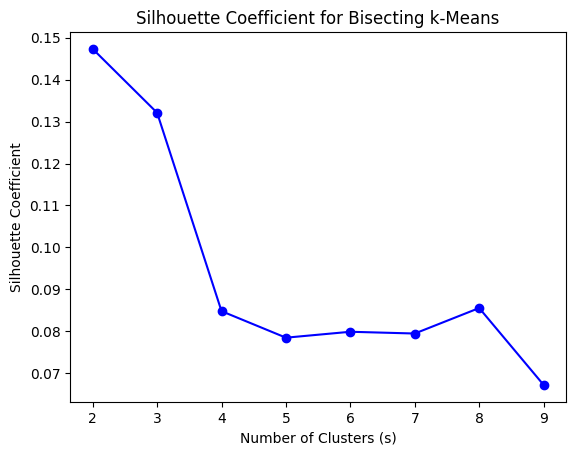

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

# Read the CSV file
df = pd.read_csv("dataset", header=None)

# Process the data
data = []
for index, row in df.iterrows():
    parts = row[0].strip().split(" ")
    numeric_parts = []
    for part in parts:
        try:
            numeric_part = float(part)
            numeric_parts.append(numeric_part)
        except ValueError:
            continue  # Skip non-numeric values
    data.append(numeric_parts)

X = np.array(data)

# Function to compute Euclidean distance
def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

# Function to initialize centroids
def initialize_centroids(X, k):
    return X[random.sample(range(X.shape[0]), k)]

# Function to assign data points to clusters
def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    return np.argmin(distances, axis=1)

# Function to update centroids
def update_centroids(X, labels, k):
    return np.array([X[labels == i].mean(axis=0) for i in range(k)])

# Function for Bisecting k-Means clustering
def bisecting_kmeans(X, k, max_iters=100):
    clusters = [X]
    while len(clusters) < k:
        largest_cluster_index = np.argmax([cluster.shape[0] for cluster in clusters])
        largest_cluster = clusters[largest_cluster_index]
        
        # Apply regular k-means to split the largest cluster into two
        centroids = initialize_centroids(largest_cluster, 2)
        for _ in range(max_iters):
            labels = assign_clusters(largest_cluster, centroids)
            new_centroids = update_centroids(largest_cluster, labels, 2)
            if np.allclose(centroids, new_centroids):
                break
            centroids = new_centroids
        
        if len(np.unique(labels)) == 1:  # Handle case of generating only one cluster
            continue
        
        # Split the largest cluster into two subclusters
        subclusters = [largest_cluster[labels == 0], largest_cluster[labels == 1]]
        
        # Update the list of clusters
        clusters.pop(largest_cluster_index)
        clusters.extend(subclusters)
    
    return clusters

# Function to compute Silhouette coefficient for a given clustering
def compute_silhouette(X, clusters):
    if len(clusters) < 2:  # Check if at least two clusters are generated
        return np.nan
    labels = np.concatenate([i * np.ones(cluster.shape[0]) for i, cluster in enumerate(clusters)])
    
    silhouette_sum = 0
    for i, cluster in enumerate(clusters):
        for point in cluster:
            a_i = np.mean([euclidean_distance(point, x) for x in cluster if not np.array_equal(point, x)])
            b_i = min([np.mean([euclidean_distance(point, x) for x in other_cluster]) for j, other_cluster in enumerate(clusters) if j != i])
            silhouette_sum += (b_i - a_i) / max(a_i, b_i)
    
    silhouette_avg = silhouette_sum / len(X)
    return silhouette_avg

# Compute Silhouette coefficient for clusterings with different numbers of clusters
s_values = []
silhouette_scores = []
for s in range(1, 10):
    clusters = bisecting_kmeans(X, s)
    silhouette = compute_silhouette(X, clusters)
    s_values.append(s)
    silhouette_scores.append(silhouette)

# Plot s vs Silhouette coefficient
plt.plot(s_values, silhouette_scores, '-bo')
plt.xlabel('Number of Clusters (s)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient for Bisecting k-Means')
plt.show()
